In [1]:
import numpy as np
import pandas as pd
from itertools import compress
import copy, sys
import matplotlib.pyplot as plt
from featureSelect_correlation import featureSelect_correlation
from pyirr import intraclass_correlation
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, StratifiedKFold, RepeatedStratifiedKFold, permutation_test_score
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, roc_curve, confusion_matrix
from scipy.stats import spearmanr

# use all the processors unless we are in debug mode
n_jobs = -1
if getattr(sys, 'gettrace', None)():
    n_jobs = 1

In [2]:
def load_two_reader_data(fileName):

    # read spreadsheet
    df = pd.read_excel(fileName, sheet_name='GG_MG')

    # remove features, as with the discovery/test data
    df.drop(['IndexLesion_GG', 'IndexLesionMG', 'GlobalStageGG', 'GlobalStageMG'], axis=1, inplace=True)

    # remove rows with missing data - need to check that this leaves the same patients for dfGG as in the discovery data set
    df.dropna(inplace=True)

    # split to each reader
    dfGG = df.filter(regex = 'GG|PID', axis = 1)
    dfMG = df.filter(regex='MG|PID', axis=1)

    # match column names by removing subscripts
    dfGG = dfGG.rename(columns=lambda x: x.replace('_GG','').replace('GG',''))
    dfMG = dfMG.rename(columns=lambda x: x.replace('_MG','').replace('MG',''))

    # change some column names to match the discovery/test data sets
    renameDict = {'LocIndexL':'AnatDev01',
                  'LocAnat':'AnatDev02',
                  'Division':'AnatDev03',
                  'DivisionLat':'AnatDev04',
                  'LesionSize':'MajorLengthIndex',
                  'SmoothCapsularBulgin':'SmoothCapsularBulging',
                  'UnsharpMargins':'UnsharpMargin',
                  'irregularContour':'IrregularContour',
                  'BlackEstrition':'BlackEstritionPeripFat',
                  'measurableECE':'MeasurableECE',
                  'retroprostaticAngleObl':'RetroprostaticAngleOblit'}
    dfGG.rename(renameDict, axis=1, inplace=True)
    dfMG.rename(renameDict, axis=1, inplace=True)

    # highsignalT1FS is missing from this spreadsheet, so fill in with default value.
    # Fortunately, this feature is not selected in the final model, but we need it there for compatibility.
    dfGG.loc[:, 'highsignalT1FS'] = 0
    dfMG.loc[:, 'highsignalT1FS'] = 0

    iccDict = {}
    for col in dfGG.drop(['PID', 'highsignalT1FS'], axis=1):
        data = np.stack((dfGG[col], dfMG[col]), axis=1)
        iccDict[col] = intraclass_correlation(data, "twoway", "agreement").value

    return dfGG, dfMG, iccDict

In [3]:
def load_data(discoveryFile, externalTestFile, twoReaderFile):
    
   # load data
    dfTrain = pd.read_csv(discoveryFile)
    dfTest  = pd.read_csv(externalTestFile)
    dfGG, dfMG, iccDict = load_two_reader_data(twoReaderFile)

    # drop features we are not going to use for classification
    dfTrain.drop(['Gleason biopsy','TumorGradeMRI'], inplace=True, axis=1)
    dfTest.drop(['Gleason biopsy','TumorGradeMRI'], inplace=True, axis=1)

    # merge with clinical features from training data
    featuresFromTrainingData = ['PID', 'GleasonBinary', 'ProstateVolume', 'PSA', 'IndLesPIRADS_V2', 'ECE_Pathology']
    dfGG = dfGG.merge(dfTrain[featuresFromTrainingData], on='PID')
    dfMG = dfMG.merge(dfTrain[featuresFromTrainingData], on='PID')

    # make sure columns are ordered the same
    dfGG = dfGG[dfTrain.columns]
    dfMG = dfMG[dfTrain.columns]

    # make these features binary 0/1
    toBinary = ['SmoothCapsularBulging' ,'CapsularDisruption', 'UnsharpMargin', 'IrregularContour', 'BlackEstritionPeripFat', 'MeasurableECE', 'RetroprostaticAngleOblit', 'highsignalT1FS']
    for tb in toBinary:
        dfTrain[tb]  = dfTrain[tb].map(dict(YES=1, NO=0))
        dfTest[tb] = dfTest[tb].map(dict(YES=1, NO=0))

    # is missing in test and training, so replace both with median from the training data
    psaTrainMedian = np.nanmedian(np.array(dfTrain.PSA))
    dfTrain.PSA.fillna(psaTrainMedian, inplace=True)
    dfTest.PSA.fillna(psaTrainMedian, inplace=True)

    # this feature is not selected in the semantic model, so this has no effect
    # fill in with the most common value
    dfTest.highsignalT1FS.fillna(0, inplace=True)

    # extract data into numpy arrays, but keep the feature names
    yTrain = np.array(dfTrain.ECE_Pathology)
    yTest = np.array(dfTest.ECE_Pathology)
    yMG_GG = np.array(dfGG.ECE_Pathology)

    XTrain = dfTrain.drop(['PID', 'ECE_Pathology'], axis=1)
    XTest = dfTest.drop(['PID', 'ECE_Pathology'], axis=1)
    X_GG = dfGG.drop(['PID', 'ECE_Pathology'], axis=1)
    X_MG = dfMG.drop(['PID', 'ECE_Pathology'], axis=1)

    featureNames = list(XTrain.columns)
    XTrain = np.array(XTrain)
    XTest = np.array(XTest)
    X_GG = np.array(X_GG)
    X_MG = np.array(X_MG)

    return XTrain, yTrain, XTest, yTest, X_GG, X_MG, yMG_GG, featureNames, iccDict

In [4]:
def fit_training_data(XTrain, yTrain, featureNames, iccDict, n_repeats=10, n_splits=10, n_permutations=10, crossValidateFit=True, printResubstitutionMetrics=False):

    # Check for data leak - this is in case the way this code is split into various functions
    # accidentally allows scope of the test data to include function.
    if 'yTest' in locals() or 'yTest' in globals():
        print('Test data is accessible to training function - check code for data leak!!!')
        return {}, None

    # reproducible execution
    seed = 42
    np.random.seed(seed)

    # logistic LASSO tuning parameter optimised using function with in-built CV
    pipeline = Pipeline(steps=[('scaler', StandardScaler()), 
                               ('logistic',LogisticRegressionCV(Cs=20, 
                                                                cv=10, 
                                                                solver="liblinear",
                                                                max_iter=10000, penalty='l1',
                                                                random_state=seed))])

    # fit to all data
    pipeline.fit(XTrain, yTrain)

    # print some performance metrics
    if printResubstitutionMetrics:
        y_pred_score = pipeline.predict_proba(XTrain)[:, 1]
        y_pred_class = pipeline.predict(XTrain)
        resubAUROC = roc_auc_score(yTrain, y_pred_score)
        resubAccuracy = accuracy_score(yTrain, y_pred_class)
        resubF1 = f1_score(yTrain, y_pred_class)

        print('AUCROC  (resub) = ' + str(np.round(resubAUROC, 3)))
        print('Accuracy (resub) = ' + str(np.round(resubAccuracy, 3)))
        print('F1 (resub) = ' + str(np.round(resubF1, 3)))
        print(' ')

    # default value for this when crossValidateFit = False
    dfCoefResults = None
    
    if crossValidateFit:

        # cross-validate
        outer_cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats)
        cv_result = cross_validate(pipeline, X=XTrain, y=yTrain, cv=outer_cv, scoring=['accuracy', 'roc_auc', 'f1'],
                                   return_estimator=True, verbose=0, n_jobs=n_jobs)

        # get frequency that features are non-zero across the repeated cv splits
        coef_cv = np.zeros((len(cv_result['estimator']), XTrain.shape[1]))
        for n, res in enumerate(cv_result['estimator']):
            coef_cv[n, :] = res._final_estimator.coef_
        coef_freq = np.sum(coef_cv != 0, axis=0) / (n_repeats * n_splits)

        # put icc values in array for including in DataFrame
        iccList = []
        for feat in featureNames:
            if feat in iccDict:
                iccList.append(iccDict[feat])
            else:
                iccList.append('-')

        # display sorted coefficients and selection frequency
        coeffs = np.squeeze(pipeline._final_estimator.coef_)
        dfCoefResults = pd.DataFrame({'Feature': featureNames, 'Coeff': coeffs, 'Freq': coef_freq, 'ICC':iccList})
        dfCoefResults.sort_values(by=['Coeff', 'Freq'], key=abs, inplace=True, ascending=False)

        # print CV scores
        print('AUCROC   (CV) = ' + str(np.mean(cv_result['test_roc_auc']).round(3)))
        print('Accuracy (CV) = ' + str(np.mean(cv_result['test_accuracy']).round(3)))
        print('F1       (CV) = ' + str(np.mean(cv_result['test_f1']).round(3)))

        # permutation testing
        outer_cv.n_repeats = 1
        scoreDirect, perm_scores, pValueDirect = permutation_test_score(pipeline, XTrain, yTrain, scoring="roc_auc",
                                                                        cv=outer_cv, n_permutations=n_permutations,
                                                                        verbose=0, n_jobs=n_jobs)

        # pValueDirect is computed using scoreDirect and assumes only one outer CV run
        # We have used repeated outer CV, so the following code correctly computes the p-value of our repeated CV performance estimate
        # Actually, it doesn't seem to make much difference, so am relaxed about that.

        p_values = []
        scores_roc_auc = np.mean(np.reshape(cv_result['test_roc_auc'], (n_repeats, -1)), axis=1)
        for score in scores_roc_auc:
            p_values.append((np.count_nonzero(perm_scores >= score) + 1) / (n_permutations + 1))
        print('p-value       = ' + str(np.mean(p_values).round(4)) + '\n\n')

    return pipeline, dfCoefResults

In [5]:
def load_fit_training_test(discoveryFile, externalTestFile, twoReaderFile, n_splits=10, n_repeats=10, n_permutations=10):

    # get all required data arrays
    XTrain, yTrain, XTest, yTest, X_GG, X_MG, yMG_GG, featureNames, iccDict = load_data(discoveryFile, externalTestFile, twoReaderFile)

    # fit training data using cross-validation and permutation testing
    pipeline, dfCoefResults = fit_training_data(XTrain, yTrain, featureNames, iccDict, 
                               n_splits=n_splits, n_repeats=n_repeats, 
                               n_permutations=n_permutations, crossValidateFit=True)

    # re-fit training data using features selected based on the frequency 
    # the logisticLASSO retains each feature being > 0.9
    selectedFeatures = ['GleasonBinary', 'MeasurableECE', 'CapsularContactLength', 
                        'IrregularContour', 'CapsularDisruption']
    XTrain_reducedModel = np.array(pd.DataFrame(XTrain, columns=featureNames)[selectedFeatures])
    XTest_reducedModel = np.array(pd.DataFrame(XTest, columns=featureNames)[selectedFeatures])
    #
    pipeline_reducedModel, _ = fit_training_data(XTrain_reducedModel, yTrain, featureNames, iccDict, crossValidateFit=False)

    # package lots of variables up into a dict for tidy output
    outputVars = ('pipeline', 'dfCoefResults', 'pipeline_reducedModel', 'XTrain', 'XTrain_reducedModel', 
                  'yTrain', 'XTest', 'XTest_reducedModel', 'yTest', 'X_GG', 'X_MG', 'yMG_GG')
    out = {}
    for var in outputVars:
        out[var] = locals()[var]
    
    return out

In [6]:
# Load data and fit models

discoveryFile = '/Users/morton/Dropbox (ICR)/CLINMAG/Radiomics/ECE_Prostate_Semantic/ECE_Semantic_Data/discovery.csv'
externalTestFile = '/Users/morton/Dropbox (ICR)/CLINMAG/Radiomics/ECE_Prostate_Semantic/ECE_Semantic_Data/external.csv'
twoReaderFile = '/Users/morton/Dropbox (ICR)/CLINMAG/Radiomics/ECE_Prostate_Semantic/ECE_Semantic_Data/GG_MG.xlsx'

n_splits=10
n_repeats=100
n_permutations=1000

result = load_fit_training_test(discoveryFile, externalTestFile, twoReaderFile, 
                                n_splits=n_splits, n_repeats=n_repeats, n_permutations=n_permutations)

# unpack dictionary to variables
locals().update(result)

AUCROC   (CV) = 0.868
Accuracy (CV) = 0.819
F1       (CV) = 0.565
p-value       = 0.001




In [7]:
pd.set_option('precision', 3)
pd.set_option('display.colheader_justify','left')
display(dfCoefResults.style.hide_index())

Feature,Coeff,Freq,ICC
GleasonBinary,0.573,0.978,-
MeasurableECE,0.395,0.999,0.787
CapsularContactLength,0.345,0.971,0.693
IrregularContour,0.309,0.970,0.417
CapsularDisruption,0.268,0.949,0.352
RetroprostaticAngleOblit,0.170,0.600,0.479
ProstateVolume,-0.139,0.607,-
AnatDev03,0.003,0.262,0.409
PSA,0.000,0.243,-
AnatDev01,0.000,0.173,0.474


In [8]:
# get scores and predicted class info
y_pred_score_test = pipeline.predict_proba(XTest)[:, 1]
y_pred_class_test = pipeline.predict(XTest)
y_pred_score_test_reducedModel = pipeline_reducedModel.predict_proba(XTest_reducedModel)[:, 1]
y_pred_class_test_reducedModel = pipeline_reducedModel.predict(XTest_reducedModel)
y_pred_score_GG = pipeline.predict_proba(X_GG)[:, 1]
y_pred_score_MG = pipeline.predict_proba(X_MG)[:, 1]

In [9]:
# test scores from main model
testAUROC = roc_auc_score(yTest, y_pred_score_test)
testAccuracy = accuracy_score(yTest, y_pred_class_test)
testF1 = f1_score(yTest, y_pred_class_test)

# test scores from reduced model
test_reducedModel_AUROC = roc_auc_score(yTest, y_pred_score_test_reducedModel)
test_reducedModel_Accuracy = accuracy_score(yTest, y_pred_class_test_reducedModel)
test_reducedModel_F1 = f1_score(yTest, y_pred_class_test_reducedModel)

In [10]:
# print the test performance metrics
print('Principle model')
print('AUCROC  (test)  = ' + str(np.round(testAUROC,3)))
print('Accuracy (test) = ' + str(np.round(testAccuracy,3)))
print('F1 (test)       = ' + str(np.round(testF1,3)))

print('\nReduced model using GleasonBinary, MeasurableECE, CapsularContactLength, IrregularContour, CapsularDisruption')
print('AUCROC   = ' + str(np.round(test_reducedModel_AUROC,3)))
print('Accuracy = ' + str(np.round(test_reducedModel_Accuracy,3)))
print('F1       = ' + str(np.round(test_reducedModel_F1,3)))
print(' ')

data = np.stack((y_pred_score_MG, y_pred_score_GG), axis=1)
iccScore = intraclass_correlation(data, "twoway", "agreement").value
print('ICC comparing GG and MG scores  = ' + str(np.round(iccScore,3)) + '\n')

Principle model
AUCROC  (test)  = 0.908
Accuracy (test) = 0.814
F1 (test)       = 0.621

Reduced model using GleasonBinary, MeasurableECE, CapsularContactLength, IrregularContour, CapsularDisruption
AUCROC   = 0.911
Accuracy = 0.814
F1       = 0.621
 
ICC comparing GG and MG scores  = 0.898



In [11]:
def roc_curve_thresholds(yTrue, yScore, thresholds):
    tnArr, fpArr, fnArr, tpArr = [], [], [], []
    nSamples = len(yTrue)
    for thresh in thresholds:
        tn, fp, fn, tp = confusion_matrix(yTrue, yScore>thresh).ravel()
        tnArr.append(tn/nSamples)
        fpArr.append(fp/nSamples)
        fnArr.append(fn/nSamples)
        tpArr.append(tp/nSamples)
    return np.array(tnArr), np.array(fpArr), np.array(fnArr), np.array(tpArr)

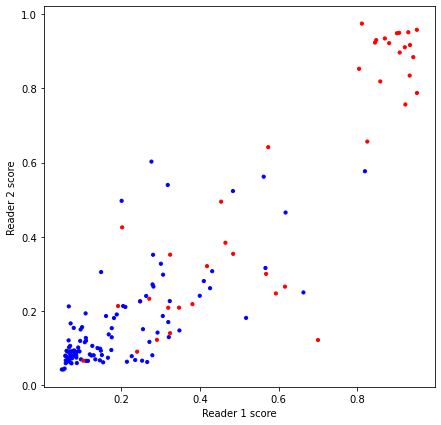

In [12]:
# plot comparing scores
fig = plt.figure(figsize=(7,7))
plt.scatter(y_pred_score_GG, y_pred_score_MG, c=yMG_GG, s=10, cmap='bwr')
plt.xlabel('Reader 1 score')
plt.ylabel('Reader 2 score')
plt.show()

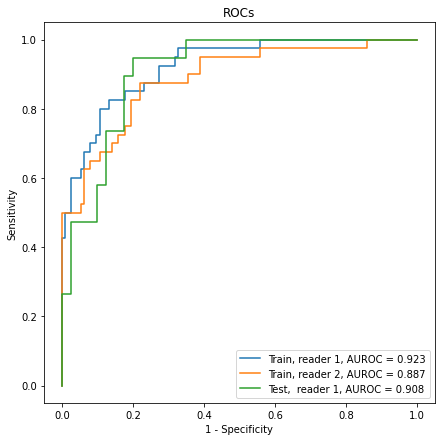

In [13]:
# plot comparing ROCs
fprGG, tprGG, _ = roc_curve(yMG_GG, y_pred_score_GG)
fprMG, tprMG, _ = roc_curve(yMG_GG, y_pred_score_MG)
fprTest, tprTest, _ = roc_curve(yTest, y_pred_score_test)

fig = plt.figure(figsize=(7,7))
plt.plot(fprGG, tprGG,     label='Train, reader 1, AUROC = ' + str(np.round(roc_auc_score(yMG_GG, y_pred_score_GG),3)))
plt.plot(fprMG, tprMG,     label='Train, reader 2, AUROC = ' + str(np.round(roc_auc_score(yMG_GG, y_pred_score_MG),3)))
plt.plot(fprTest, tprTest, label='Test,  reader 1, AUROC = ' + str(np.round(roc_auc_score(yTest, y_pred_score_test),3)))
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.title('ROCs')
plt.legend()
plt.show()

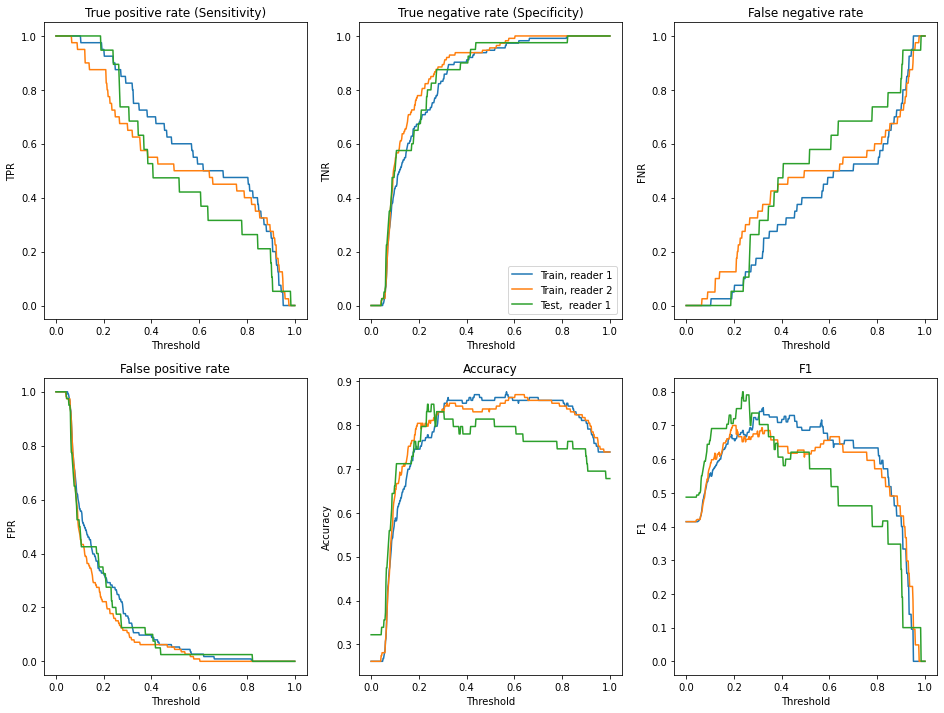

In [14]:
# plots comparing TP, FP, Sensitivity etc.

thresh = np.linspace(0, 1, 500)
tnTest, fpTest, fnTest, tpTest = roc_curve_thresholds(yTest, y_pred_score_test, thresh)
tnGG, fpGG, fnGG, tpGG = roc_curve_thresholds(yMG_GG, y_pred_score_GG, thresh)
tnMG, fpMG, fnMG, tpMG = roc_curve_thresholds(yMG_GG, y_pred_score_MG, thresh)

_, ax = plt.subplots(2,3, figsize=(16,12))
ax = ax.ravel()

ax[0].plot(thresh, tpGG/(tpGG + fnGG), label='Train, reader 1')
ax[0].plot(thresh, tpMG/(tpMG + fnMG), label='Train, reader 2')
ax[0].plot(thresh, tpTest/(tpTest + fnTest), label='Test,  reader 1')
ax[0].set_title('True positive rate (Sensitivity)')
ax[0].set_xlabel('Threshold')
ax[0].set_ylabel('TPR')

ax[1].plot(thresh, tnGG/(tnGG + fpGG), label='Train, reader 1')
ax[1].plot(thresh, tnMG/(tnMG + fpMG), label='Train, reader 2')
ax[1].plot(thresh, tnTest/(tnTest + fpTest), label='Test,  reader 1')
ax[1].set_title('True negative rate (Specificity)')
ax[1].set_xlabel('Threshold')
ax[1].set_ylabel('TNR')
ax[1].legend()

ax[2].plot(thresh, fnGG/(fnGG + tpGG))
ax[2].plot(thresh, fnMG/(fnMG + tpMG))
ax[2].plot(thresh, fnTest/(fnTest + tpTest))
ax[2].set_title('False negative rate')
ax[2].set_xlabel('Threshold')
ax[2].set_ylabel('FNR')

ax[3].plot(thresh, fpGG/(fpGG + tnGG))
ax[3].plot(thresh, fpMG/(fpMG + tnMG))
ax[3].plot(thresh, fpTest/(fpTest + tnTest))
ax[3].set_title('False positive rate')
ax[3].set_xlabel('Threshold')
ax[3].set_ylabel('FPR')

ax[4].plot(thresh, (tnGG + tpGG)/(tpGG + fnGG + tnGG + fpGG))
ax[4].plot(thresh, (tnMG + tpMG)/(tpMG + fnMG + tnMG + fpMG))
ax[4].plot(thresh, (tnTest + tpTest)/(tpTest + fnTest + tnTest + fpTest))
ax[4].set_title('Accuracy')
ax[4].set_xlabel('Threshold')
ax[4].set_ylabel('Accuracy')

ax[5].plot(thresh, 2*tpGG/(2*tpGG + fnGG + fpGG))
ax[5].plot(thresh, 2*tpMG/(2*tpMG + fnMG + fpMG))
ax[5].plot(thresh, 2*tpTest/(2*tpTest + fnTest + fpTest))
ax[5].set_title('F1')
ax[5].set_xlabel('Threshold')
ax[5].set_ylabel('F1')

plt.show()


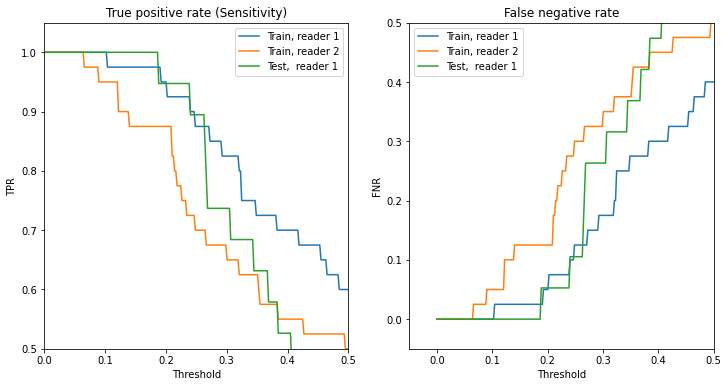

In [15]:
_, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].plot(thresh, tpGG/(tpGG + fnGG), label='Train, reader 1')
ax[0].plot(thresh, tpMG/(tpMG + fnMG), label='Train, reader 2')
ax[0].plot(thresh, tpTest/(tpTest + fnTest), label='Test,  reader 1')
ax[0].set_title('True positive rate (Sensitivity)')
ax[0].set_xlim([0, 0.5])
ax[0].set_ylim([0.5, 1.05])
ax[0].legend()
ax[0].set_xlabel('Threshold')
ax[0].set_ylabel('TPR')

ax[1].plot(thresh, fnGG/(fnGG + tpGG), label='Train, reader 1')
ax[1].plot(thresh, fnMG/(fnMG + tpMG), label='Train, reader 2')
ax[1].plot(thresh, fnTest/(fnTest + tpTest), label='Test,  reader 1')
ax[1].set_title('False negative rate')
ax[1].set_xlim([-0.05, 0.5])
ax[1].set_ylim([-0.05, 0.5])
ax[1].legend()
ax[1].set_xlabel('Threshold')
ax[1].set_ylabel('FNR')

plt.show()

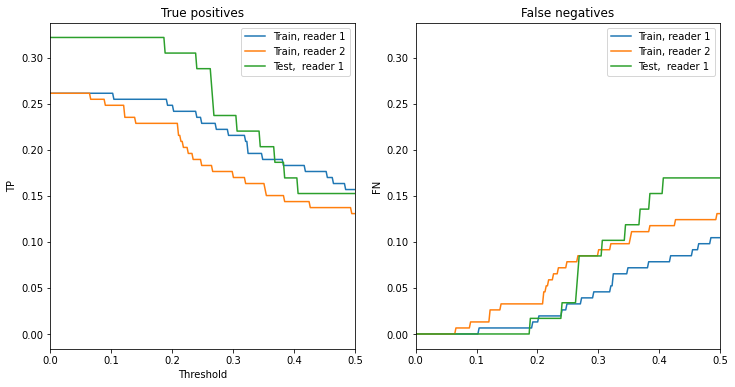

In [16]:
_, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].plot(thresh, tpGG, label='Train, reader 1')
ax[0].plot(thresh, tpMG, label='Train, reader 2')
ax[0].plot(thresh, tpTest, label='Test,  reader 1')
ax[0].set_xlim([0, 0.5])
ax[0].legend()
ax[0].set_xlabel('Threshold')
ax[0].set_ylabel('TP')
ax[0].set_title('True positives')

ax[1].plot(thresh, fnGG, label='Train, reader 1')
ax[1].plot(thresh, fnMG, label='Train, reader 2')
ax[1].plot(thresh, fnTest, label='Test,  reader 1')
ax[1].set_title('False negatives')
ax[1].set_xlim([0, 0.5])
#ax[1].set_ylim([0, 0.5])
ax[1].legend()
ax[0].set_xlabel('Threshold')
ax[1].set_ylabel('FN')

plt.show()